In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from adjustText import adjust_text
from coolpuppy.lib import io
from scipy import stats
import scipy

In [2]:
os.chdir("/path/")

In [3]:
TFs = pd.read_csv("Mus_musculus_TF.txt", sep="\t")
TFs["Factor"] = TFs["Symbol"].str.upper()

In [4]:
Cofactor = pd.read_csv("Mus_musculus_TF_cofactors.txt", sep="\t")
Cofactor["Factor"] = Cofactor["Symbol"].str.upper()

In [5]:
pup_data = io.load_pileup_df("Hsieh_mESCs_microC.mm10.mapq_30.1000_mm10-cCREs_ESC_DNase_merged5kb_mm10.bed_expected_noflank_10kbres_100kbto10Mb_stripe.clpy")

In [6]:
def process_pup(pup):
    pup = pup[pup["separation"] != "all"]
    contact_freq = pd.DataFrame({"chrom": [item[0] for sublist in pup["coordinates"] for item in sublist],
                                 "start1": [int(item[1]) for sublist in pup["coordinates"] for item in sublist],
                                 "end1": [int(item[2]) for sublist in pup["coordinates"] for item in sublist],
                                 "start2": [int(item[4]) for sublist in pup["coordinates"] for item in sublist],
                                 "end2": [int(item[5]) for sublist in pup["coordinates"] for item in sublist],
                                 "distance_band": ''.join([str(item)*pup.loc[pup["distance_band"] == item, "vertical_stripe"].reset_index(drop=True)[0].shape[0] for item in pup["distance_band"]]).split(")("),                    
                                 "contact": [item[0] for sublist in pup["vertical_stripe"] for item in sublist]})
    contact_freq["distance_band"] = contact_freq["distance_band"].str.replace('(','', regex=False)
    contact_freq["distance_band"] = contact_freq["distance_band"].str.replace(')','', regex=False)
    contact_freq["coord1"] = contact_freq["chrom"] + "_" + contact_freq["start1"].astype(str) + "_" + contact_freq["end1"].astype(str)
    contact_freq["coord2"] = contact_freq["chrom"] + "_" + contact_freq["start2"].astype(str) + "_" + contact_freq["end2"].astype(str)
    contact_freq = contact_freq.dropna()
    return contact_freq

In [7]:
contact_freq = process_pup(pup_data)

In [8]:
peakset = pd.read_csv("mm10-cCREs_ESC_DNase_merged5kb_mm10_cistromeDB_ReMap2020_filtered.bed", 
                      sep="\t", dtype={"chrom_cres": str, 
                                       "start_cres": int, 
                                       "end_cres": int, 
                                       "ID": str})

In [9]:
#Manual annotation of groups
TF = TFs["Factor"].tolist() + ["SMAD2/3", "SMAD2-3", 'ISL1-2']
Cofactors = Cofactor["Factor"].tolist() + ["ZNF143", "CFP1", "RPB1", "KMT2D", "CHD2", "SUPT5H"]
Cohesin = ['CTCF', 'SMC1A', 'RAD21', 'STAG1', 'STAG2', 'SMC3', 'WAPL', 'NIPBL']
Polycomb = ['PHC1', 'RING1B', 'RING1A', 'RING1B', 'EED', 'EZH2', 'CBX2', 'SUZ12', 
            'CBX7',  'RBP1', 'MTF2', 'PCGF2', 'RYBP', 'KDM2B', 'BAP1',
            'PCGF6', 'CBX6', 'PCGF1', 'PHF19', 'CBX8', 'JARID2', 'EPOP']
Repressive = ['CHD4', 'TRIM28', 'SINHCAF', 'TET1', 'TET3', 'SIN3A', 'DNMT3B', 
              'REST', 'HEXIM1', 'CBX1', 'CBX5', 'CBX3']

In [10]:
#Rename factors (RBP1 misnamed in GEO)
peakset["Factor"] = np.where(peakset["Factor"] == "RNF2", "RING1B", peakset["Factor"])
peakset["Factor"] = np.where(peakset["Factor"] == "CXXC1", "CFP1", peakset["Factor"])
peakset["Factor"] = np.where(peakset["Factor"] == "POLR2A", "RPB1", peakset["Factor"])
peakset["Factor"] = np.where(peakset["ID_Factor"] == "GSE137491_RBP1", "RPB1", peakset["Factor"])

In [11]:
peakset["Group"] = "Other"
peakset.loc[peakset["Factor"].isin(TF),"Group"] = "TF"
peakset.loc[peakset["Factor"].isin(Cofactors),"Group"] = "Co-factors"
peakset.loc[peakset["Factor"].isin(Repressive),"Group"] = "Repressive"
peakset.loc[peakset["Factor"].isin(Polycomb),"Group"] = "Polycomb"
peakset.loc[peakset["Factor"].isin(Cohesin),"Group"] = "Cohesin"

In [20]:
store_data = {"Factor": [], "F_both": [], "F_one": [], 
              "p_both": [], "p_one": []}
contact_df = contact_freq.loc[contact_freq["distance_band"] == "1000000, 10000000", ["coord1", "coord2", "contact"]]
coord1 = set(contact_df["coord1"].unique())
coord2 = set(contact_df["coord2"].unique())
factors = peakset.loc[peakset["Group"]=="TF","Factor"].unique()
i = 1
counter = 0
for factor in factors:
    percent = (i / len(factors))*100
    i += 1
    if (percent>counter) & (np.floor(percent)%10 == 0):
        print(str(np.floor(percent))+"% finished")
        counter += 10
    factor_regions = set(peakset.loc[peakset["Factor"] == factor, "coords_cre"])
    tf_regions = set(peakset.loc[peakset["Factor"].isin(factors[factors != factor]), "coords_cre"])
    if len(factor_regions) < 500:
        continue
    left_factor = coord1.intersection(factor_regions)
    right_factor = coord2.intersection(factor_regions)
    left_tf = coord1.intersection(tf_regions)
    right_tf = coord2.intersection(tf_regions)
    none = contact_df.loc[~(contact_df["coord1"].isin(left_factor.union(left_tf))) & 
                          ~(contact_df["coord2"].isin(right_factor.union(right_tf))), "contact"]
    one = contact_df.loc[((contact_df["coord1"].isin(left_factor)) & 
                          ~(contact_df["coord2"].isin(right_factor)) &
                          (contact_df["coord2"].isin(right_tf))) |
                          (~(contact_df["coord1"].isin(left_factor)) & 
                          (contact_df["coord2"].isin(right_factor)) &
                          (contact_df["coord1"].isin(left_tf))), "contact"]
    both = contact_df.loc[(contact_df["coord1"].isin(left_factor)) & 
                          (contact_df["coord2"].isin(right_factor)), "contact"]
    if (len(one)>50) & (len(none)>50) & (len(both)>50):
        MannWhitney_both = stats.mannwhitneyu(y = none, x = both)
        MannWhitney_one = stats.mannwhitneyu(y = none, x = one)
        store_data['Factor'].append(factor)
        store_data['F_both'].append(MannWhitney_both[0] / (len(none) * len(both)))
        store_data['F_one'].append(MannWhitney_one[0] / (len(none) * len(one)))
        store_data['p_both'].append(MannWhitney_both[1])
        store_data['p_one'].append(MannWhitney_one[1])
print("100.0% finished")
store_data = pd.DataFrame(store_data)

0.0% finished
10.0% finished
20.0% finished
30.0% finished
40.0% finished
50.0% finished
60.0% finished
70.0% finished
80.0% finished
90.0% finished
100.0% finished


In [21]:
merge = pd.merge(store_data, peakset[["Factor", "Group"]], on="Factor", how="left").drop_duplicates()

In [22]:
merge

,Factor,F_both,F_one,p_both,p_one,Group
0,MTA1,0.636034,0.586757,0.0,9.684464e-299,TF
19259,NANOG,0.603035,0.566325,0.0,1.507277e-182,TF
177020,TCF3,0.631279,0.576871,0.0,2.925491e-239,TF
201681,PRDM14,0.623385,0.587613,0.0,2.251119e-304,TF
221368,GABPA,0.656370,0.589307,0.0,0.000000e+00,TF
...,...,...,...,...,...,...
1625358,TAL1,0.627351,0.603244,0.0,0.000000e+00,TF
1630932,FLI1,0.654948,0.603082,0.0,0.000000e+00,TF
1637690,TFAP2C,0.669222,0.608969,0.0,0.000000e+00,TF
1643882,HOXB4,0.641321,0.605615,0.0,0.000000e+00,TF


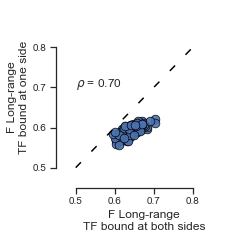

In [44]:
cm = 1/2.54
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":15, 
                                "axes.labelsize":12, "xtick.labelsize": 10,
                                "ytick.labelsize": 10})  
r, pvalue = scipy.stats.spearmanr(merge["F_both"], 
                                  merge["F_one"])
plt.figure(figsize=(8*cm, 8*cm))
g = sns.scatterplot(data=merge, x="F_both", y="F_one",                 
                alpha=0.9, s=75, 
                edgecolor='black', linewidth = 0.75)

g.set(title='', xlabel="F Long-range\nTF bound at both sides", 
      ylabel = "F Long-range\nTF bound at one side",
      xlim=[0.45, 0.9], ylim=[0.45, 0.9])
plt.xticks([0.5, 0.6, 0.7, 0.8])
plt.yticks([0.5, 0.6, 0.7, 0.8])
plt.plot([0.5, 0.8], [0.5,0.8], 'black', alpha=1, dashes=(5, 10))
plt.text(0.5, 0.7, str(r'$\rho$' + f' = {r:.2f}'), horizontalalignment='left', size=12)
sns.despine(trim=True, offset=0)
plt.tight_layout()
plt.savefig("./plots/mESC_TF_long_one_vs_both.svg", bbox_inches="tight")

In [29]:
np.max(merge["p_one"])

2.2397687081581574e-132